In [2]:
import re
import sys
import os.path as osp
import json
import os
import jieba
import jieba.analyse
from scipy.misc import imread
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
sns.set(font='Arial Unicode MS')  # 解决Seaborn中文显示问题

jieba.analyse.set_stop_words('stopwords.txt')

In [4]:
# config配置读取

try:
    config_path = osp.split(osp.abspath(''))[0] + os.sep + 'eda_config.json'
    if not os.path.isfile(config_path):
        sys.exit(u'当前路径：%s 不存在配置文件config.json' %
                    (os.path.split(os.path.realpath(__file__))[0] + os.sep))
    with open(config_path) as f:
        try:
            config = json.loads(f.read())
        except ValueError:
            sys.exit(u'eda_config.json 格式不正确')
except Exception as e:
    print('Error: ', e)
    traceback.print_exc()

fp = config['csv_file_path']
bozhu = config['csv_file_path'].split('/')[-2]
# 存储文件夹
os.makedirs(bozhu, exist_ok=True)
if config['use_image']:
    cmd = f"cp {config['image_path']} {bozhu}"
    os.system(cmd)
fp, bozhu

('/Users/Echo/Documents/code2020/weibospider/weibo/万能的老师/1765758710.csv',
 '万能的老师')

In [6]:
# 加载数据
weibo = pd.read_csv(fp)
print("Weibo shape : ", weibo.shape)
weibo.head(1)


Weibo shape :  (2113, 12)


,微博id,微博正文,原始图片url,被转发微博原始图片url,是否为原创微博,微博视频url,发布位置,发布时间,发布工具,点赞数,转发数,评论数
0,HDMA21IBU,[置顶]每人推荐一本自己认为的好书，我负责评论区分享~为满足更多人对格式的需求，每本书尽量以...,无,无,True,无,无,2019-07-16 22:58,微博 weibo.com,7708,8525,7335


In [8]:
#1-0 画词云
content=' '.join(weibo['微博正文'].tolist())

key_words = jieba.analyse.extract_tags(content, topK=2000, withWeight=True, 
                                        allowPOS=('v','vd','n','nr','ns','nt','nz'))
key_words = {p[0]:p[1] for p in key_words}


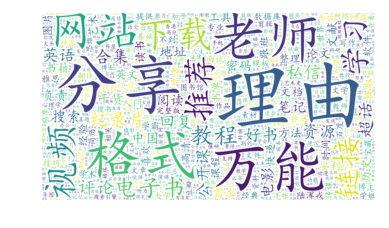

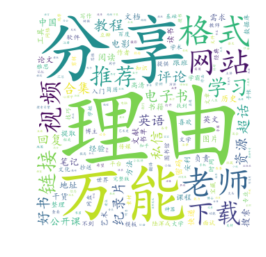

In [10]:
# 1-1 画词云
# 画云图
def plot_pic(save_path):
    wc.generate_from_frequencies(key_words)
    wc.to_file(save_path)
    # plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off") # 关掉图像的坐标
    plt.show()

wc = WordCloud(font_path='KaiTi.ttf',
            max_words=2000,
            width=1920,
            height=1080,
            background_color="white",
            margin=5)
plot_pic(f'{bozhu}/word_cloud_pic.png')
if config["use_image"] == 1:
    img_mask = np.array(Image.open(config['image_path']))
    wc = WordCloud(font_path='KaiTi.ttf',
                max_words=2000,
                mask=img_mask,
                width=1920,
                height=1080,
                background_color="white",
                margin=5)
    plot_pic(f'{bozhu}/word_cloud_pic_with_image.png')
# 1、传入[（key，weighft{bozhu}/）,...]列表生成词云


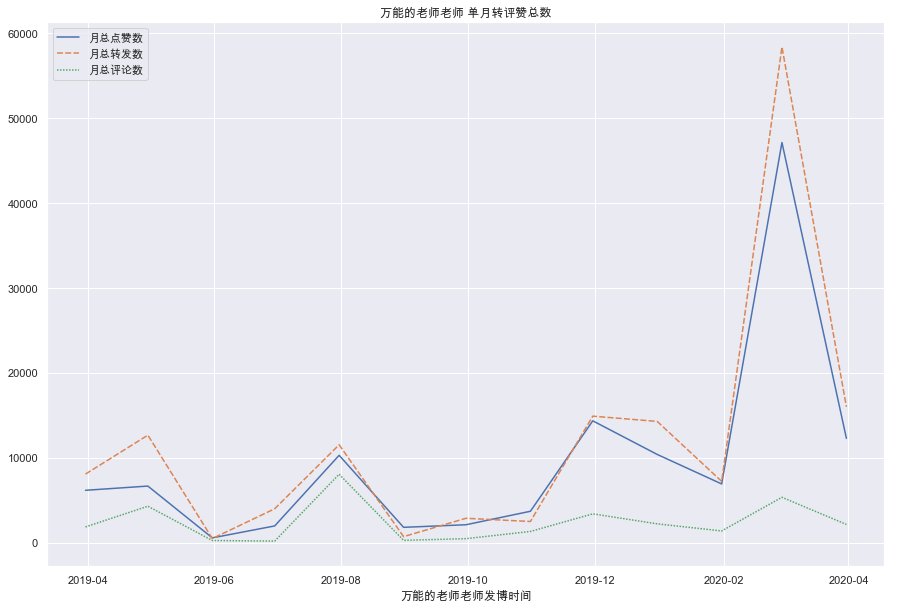

In [12]:
# 2-转评赞曲线图
publish_data = pd.read_csv(fp, index_col="发布时间", parse_dates=True)[['点赞数','转发数','评论数']]
# publish_data = pd.concat([pd.read_csv(fp1, index_col="发布时间", parse_dates=True), pd.read_csv(fp2, index_col="发布时间", parse_dates=True)])[['点赞数','转发数','评论数']]

avg_M_df = publish_data.resample('M').sum()
avg_M_df.rename(columns={'点赞数': '月总点赞数', '转发数': '月总转发数', '评论数': '月总评论数'}, inplace=True) 
avg_M_df.index.name = f'{bozhu}老师发博时间'
plt.figure(figsize=(15,10))
plt.title(f"{bozhu}老师 单月转评赞总数")
sns_plot = sns.lineplot(data=avg_M_df)
plt.savefig(f"{bozhu}/pic2.png", bbox_inches='tight', dpi=300)

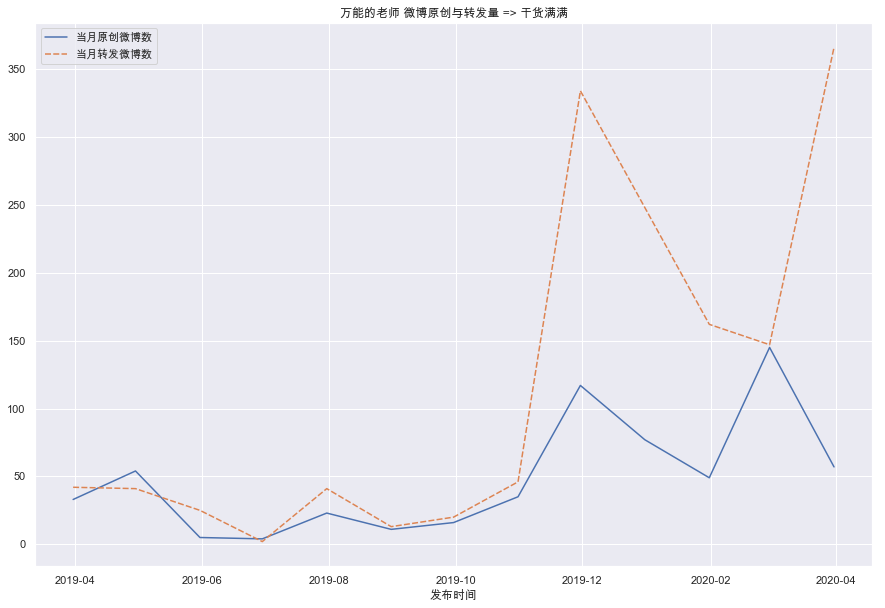

In [14]:
# 3-原创转发数
publish_data = pd.read_csv(fp, index_col="发布时间", parse_dates=True)[['是否为原创微博']].astype('int')
yuanchuang = publish_data[publish_data['是否为原创微博'] == 1]
zhuanfa = publish_data[publish_data['是否为原创微博'] == 0]

zhuanfa['转发'] = zhuanfa['是否为原创微博'].apply(lambda x: 1)

yuanchuang = yuanchuang.resample('M').sum()
zhuanfa = zhuanfa.resample('M').sum()
df = pd.merge(yuanchuang['是否为原创微博'], zhuanfa['转发'], how='left', on='发布时间').fillna(0).astype('int')
df.head()
df.rename(columns={'是否为原创微博': '当月原创微博数', '转发': '当月转发微博数'}, inplace=True) 

plt.figure(figsize=(15,10))
plt.title(f"{bozhu} 微博原创与转发量 => 干货满满")
sns.lineplot(data=df)
# plt.axhline(y=30, xmin=0.0, xmax=0.99, color='r', linestyle = "--", linewidth=3)
plt.savefig(f"{bozhu}/pic3.png", bbox_inches='tight',dpi=300)
plt.show()


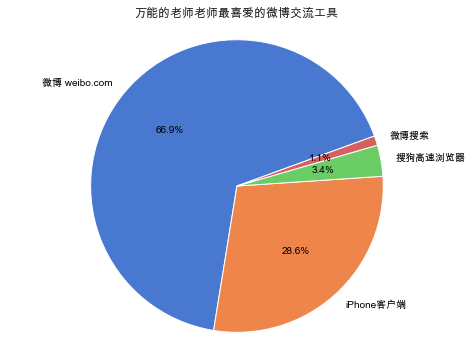

In [16]:
# 4 饼图-发布工具，原创转发比

publish_tool = pd.read_csv(fp)[['发布工具']]

t = sum(publish_tool['发布工具'].value_counts()) * 0.008
new_dict = {k:v for k,v in dict(publish_tool['发布工具'].value_counts()).items() if k.strip() != '无' and v > t}
new_dict = {k:v/sum(new_dict.values()) for k,v in new_dict.items()}
data = pd.Series(new_dict)

plt.rcParams['figure.figsize'] = (8.0, 6.0)   #调整图片大小

lbs= data.index
explodes=[0.1 if i=='iPhone 8' else 0 for i in lbs]
plt.pie(data, explode=explodes,labels=lbs, autopct="%1.1f%%",
                                colors=sns.color_palette("muted"),startangle = 20,pctdistance = 0.6,
          textprops={'fontsize':10,'color':'black'})

plt.title(f"{bozhu}老师最喜爱的微博交流工具")
plt.axis('equal')  # 设置x，y轴刻度一致，以使饼图成为圆形。
plt.savefig(f"{bozhu}/pic4.png", dpi=300, bbox_inches='tight')
plt.show()
